In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter
from torch.autograd import Variable

plt.ion()   # interactive mode
%matplotlib inline

Load Data
---------


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

data_dir = '../data/KDEF'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
x, y = next(iter(dataloaders['train']))
print(x.shape)
print(y.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128])


### Visualize a few images


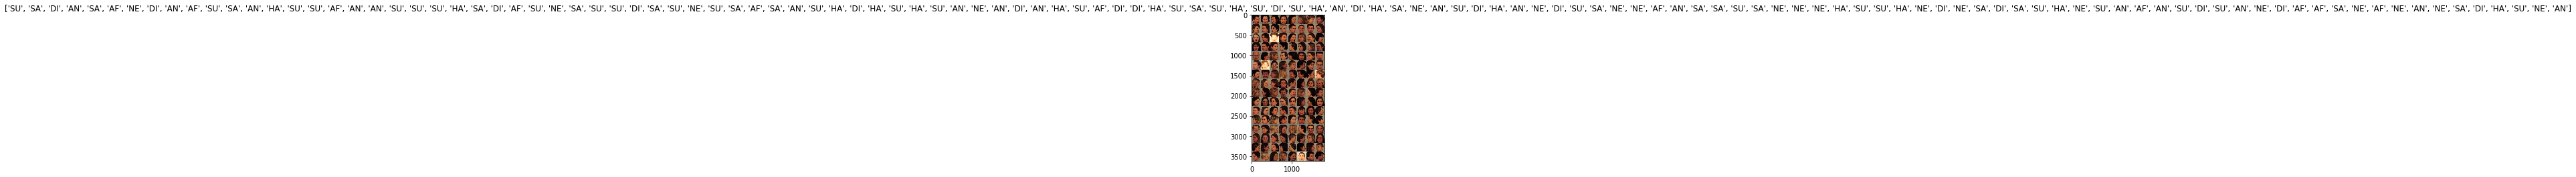

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
import torch.nn.functional as F
from torch.autograd import Variable

def center_loss(x, y, n_cls):
    x_mean = torch.zeros_like(x)
    
    for k in range(n_cls):
        idx = Variable(torch.cuda.LongTensor([i for (i, x) in enumerate(y) if int(x.cpu().data.numpy())==k ]))
        
        if idx.size()[0] > 0:
            mean = torch.mean(x.index_select(0, idx), 0)
            x_mean[idx] = mean
    
    return F.mse_loss(x, x_mean)

In [6]:
import torch.nn.functional as F

def island_loss(x, y, n_cls, gamma1):
    x_mean = torch.zeros_like(x).cuda()
    class_means = torch.zeros(n_cls, x.size()[1]).cuda() + 0.000000001
    
    for k in range(n_cls):
        idx = Variable(torch.cuda.LongTensor([i for (i, x) in enumerate(y) if int(x.cpu().data.numpy())==k ]))
        
        if idx.size()[0] > 0:
            mean = torch.mean(x.index_select(0, idx), 0)
            x_mean[idx] = mean
            class_means[k] = mean
            
    loss = 0.0
    for i in range(n_cls):
        for j in range(n_cls):
            if i != j:
                prod = (class_means[i].dot(class_means[j]) / (torch.norm(class_means[i], 2) * torch.norm(class_means[j], 2)) ) +1
                loss += prod
    return F.mse_loss(x, x_mean) + gamma1*loss

In [7]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, gamma, gamma1, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_cce_loss = 0.0
            running_ctr_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in (dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    features, outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    cce_loss = criterion(outputs, labels) 
                    ctr_loss = island_loss(features, labels, len(class_names), gamma1)
                    loss = cce_loss + gamma * ctr_loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_cce_loss += cce_loss.item() * inputs.size(0)
                running_ctr_loss += ctr_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_loss_cce = running_cce_loss / dataset_sizes[phase]
            epoch_loss_ctr = running_ctr_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Crossentropy: {:.4f} IslandLoss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_loss_cce, epoch_loss_ctr,  epoch_acc))
            
            if writer is not None:
                writer.add_scalar(phase+"/loss", epoch_loss, epoch)
                writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Build on separate classifier class

In [8]:
class classifier(nn.Module):
    def __init__(self, inter_dim):
        super(classifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, inter_dim)
        self.fc = nn.Linear(in_features=inter_dim, out_features=len(class_names),bias=True)
        
    def forward(self, x):
        x = self.model(x)
        return x, self.fc(x)

In [ ]:
model_ft = classifier(inter_dim=100)
# print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, gamma=0.25, gamma1=0.1,
                       #writer = SummaryWriter('./logs/resnet18_islandloss_lr=.01_gamma=.5_gamma1=1.0_'),
                       num_epochs=50)